### Imports

In [1]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from skimage import io, img_as_ubyte
from skimage.transform import resize
import ot

from sklearn import cluster

from tqdm import tqdm

import sys

from utils import MK, monge

import time

## Image Loading and Quantization

In [2]:
n_clusters = 3000

In [3]:
source = img_as_ubyte(io.imread('images/ste_victoire.jpg'))
target = img_as_ubyte(io.imread('images/starry_night.jpg'))
reshaped_target = img_as_ubyte(resize(target, source.shape[:2]))

/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=3000. Setting it to 3*k
  init_size=init_size)


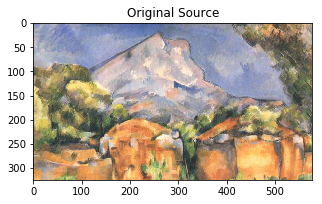

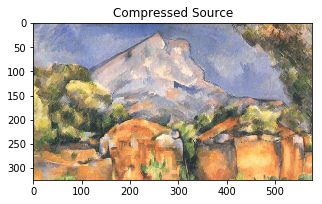

In [4]:
### Kmeans on the source

np.random.seed(0)

X = source.reshape((-1, 3))  # We need an (n_sample, n_feature) array
source_k_means = cluster.MiniBatchKMeans(n_clusters=n_clusters, n_init=4, batch_size=100)
source_k_means.fit(X)
source_values = source_k_means.cluster_centers_.squeeze()
source_labels = source_k_means.labels_

# create an array from labels and values
#source_compressed = np.choose(labels, values)
source_compressed = source_values[source_labels]
source_compressed.shape = source.shape

vmin = source.min()
vmax = source.max()

# original image
plt.figure(1, figsize=(5, 5))
plt.title("Original Source")
plt.imshow(source,  vmin=vmin, vmax=256)

# compressed image
plt.figure(2, figsize=(5, 5))
plt.title("Compressed Source")
plt.imshow(source_compressed.astype('uint8'),  vmin=vmin, vmax=vmax)

/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=3000. Setting it to 3*k
  init_size=init_size)


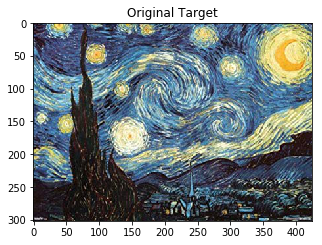

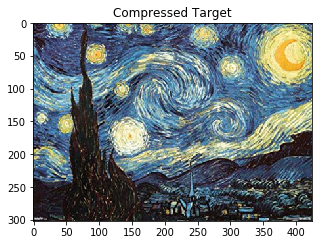

In [5]:
### Kmeans on the target

np.random.seed(0)

X = target.reshape((-1, 3))  # We need an (n_sample, n_feature) array
target_k_means = cluster.MiniBatchKMeans(n_clusters=n_clusters, n_init=4, batch_size=100)
target_k_means.fit(X)
target_values = target_k_means.cluster_centers_.squeeze()
target_labels = target_k_means.labels_

# create an array from labels and values
target_compressed = target_values[target_labels]
target_compressed.shape = target.shape

vmin = target.min()
vmax = target.max()

# original image
plt.figure(1, figsize=(5, 5))
plt.title("Original Target")
plt.imshow(target,  vmin=vmin, vmax=256)

# compressed image
plt.figure(2, figsize=(5, 5))
plt.title("Compressed Target")
plt.imshow(target_compressed.astype('uint8'),  vmin=vmin, vmax=vmax)

## Grayscale transport

In [6]:
gray_vec = np.array([0.3, 0.59, 0.11])

In [7]:
s = np.array(source_values).reshape(-1, 3).astype('long')
t = np.array(target_values).reshape(-1, 3).astype('long')

gray_source = (source_values.dot(gray_vec).astype('long'))
gray_target = (target_values.dot(gray_vec).astype('long'))

In [8]:
start_mk = time.time()

gray_source_sorted = np.argsort(gray_source)
gray_target_sorted = np.argsort(gray_target)

### 1D OT pairs

gray_transport = np.array(list(zip(gray_source_sorted, gray_target_sorted)))

### Transport disintegrations

gamma_gray = {}

for i in range(len(gray_source_sorted)):
    if gray_source[gray_source_sorted[i]] in gamma_gray:
        gamma_gray[gray_source[gray_source_sorted[i]]].append(gray_transport[i])
    else:
        gamma_gray[gray_source[gray_source_sorted[i]]] = [gray_transport[i]]
        
gray_transf = np.zeros_like(s)

for col in tqdm(gamma_gray):
    x, y = np.array(gamma_gray[col]).T
    n = len(x)
    a = b = np.ones(n) / n
    #dists = ((np.delete(s[x], c, 1)[:, None, :] - np.delete(t[y], c, 1))**2).sum(axis=2)
    dists = ((s[x][:, None, :] - t[y])**2).sum(axis=2)
    i, j = np.nonzero(ot.emd(a, b, dists))
    gray_transf[x[i]] = t[y[j]]
    
end_mk = time.time()

print(('MK transfer ran in {}s').format(end_mk-start_mk))

100%|██████████| 196/196 [00:00<00:00, 6840.95it/s]

MK transfer ran in 0.03761005401611328s


In [9]:
img_gray_transf = gray_transf[source_labels].reshape(source.shape).astype('uint8')

/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


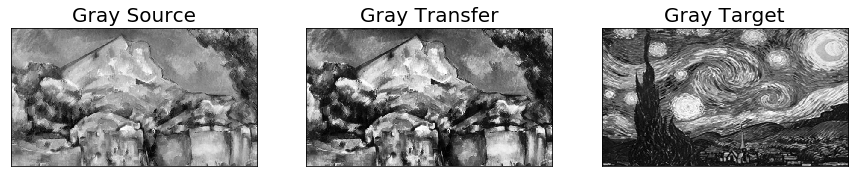

In [10]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(source_values[source_labels].dot(gray_vec).reshape(source.shape[:-1]).astype('uint8'), cmap=plt.cm.gray)
ax[1].imshow(img_gray_transf.dot(gray_vec).reshape(source.shape[:-1]).astype('uint8'), cmap=plt.cm.gray)
ax[2].imshow(img_as_ubyte(resize(target_values[target_labels].dot(gray_vec).reshape(target.shape[:-1]).astype('uint8'), source.shape[:2])), cmap=plt.cm.gray)

ax[0].set_title('Gray Source', fontsize = 20)
ax[1].set_title('Gray Transfer', fontsize = 20)
ax[2].set_title('Gray Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

## Vanilla transport

In [11]:
s = np.array(source_values).reshape(-1, 3).astype('long')
t = np.array(target_values).reshape(-1, 3).astype('long')

In [12]:
ot_transf = np.zeros_like(source_values)

dists = ((s[:, None, :] - t)**2).sum(axis=2)
n = len(s)
a = np.ones(n) / n
b = np.ones(n) / n
start_ot = time.time()
i, j = np.nonzero(ot.lp.emd(a, b, dists, numItermax=500000,))
end_ot = time.time()

ot_transf = target_values[j]

print(("Vanilla OT ran in {}s").format(end_ot - start_ot))

Vanilla OT ran in 3.2040910720825195s


In [13]:
img_ot_transf = ot_transf[source_labels].reshape(source.shape).astype('uint8')

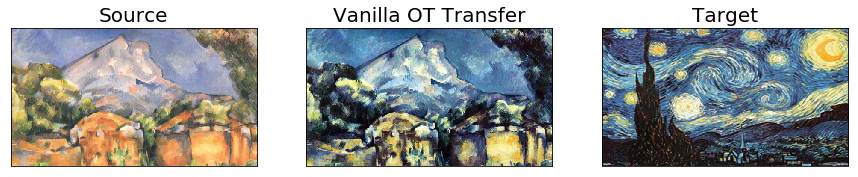

In [14]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(source)
ax[1].imshow(img_ot_transf)
ax[2].imshow(reshaped_target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('Vanilla OT Transfer', fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

## Sliced OT

In [15]:
num_projs = 100

In [16]:
sliced_values = np.zeros_like(source_values)

start_sliced = time.time()

for k in range(num_projs):
    u = np.random.randn(3)
    u /= np.linalg.norm(u)
    proj_source = (source_values.dot(u).astype('long'))
    proj_target = (target_values.dot(u).astype('long'))
    
    proj_source_sorted = np.argsort(proj_source)
    proj_target_sorted = np.argsort(proj_target)
    
    sliced_values[proj_source_sorted] += target_values[proj_target_sorted]
    
sliced_values /= num_projs

end_sliced = time.time()

print(("Sliced OT ran in {}s").format(end_sliced - start_sliced))

Sliced OT ran in 0.0484769344329834s


In [17]:
img_sliced_transf = sliced_values[source_labels].reshape(source.shape).astype('uint8')

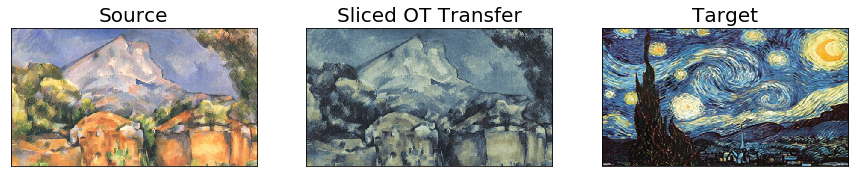

In [18]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(source)
ax[1].imshow(img_sliced_transf)
ax[2].imshow(reshaped_target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('Sliced OT Transfer', fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

## Recap

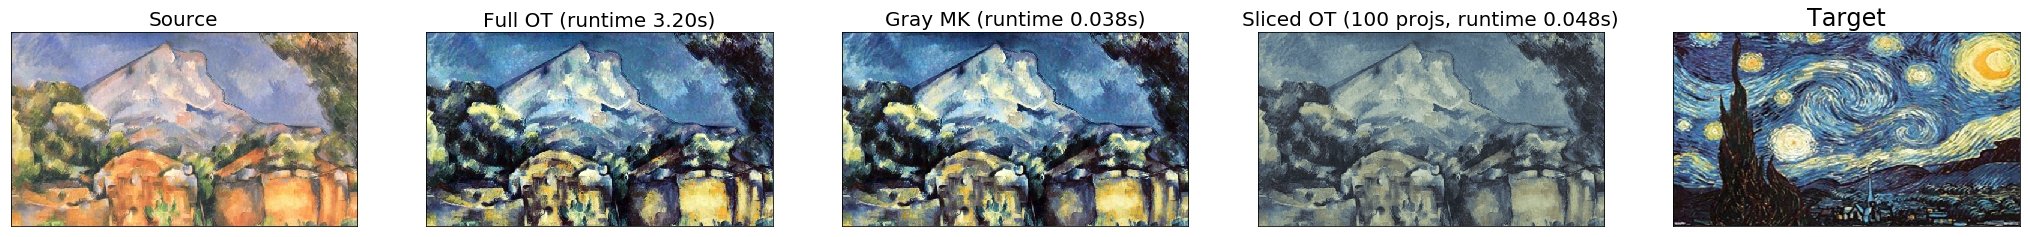

In [19]:
f, ax = plt.subplots(1, 5, figsize=(36, 6))

ax[0].imshow(source)
ax[1].imshow(img_ot_transf)
ax[2].imshow(img_gray_transf)
ax[3].imshow(img_sliced_transf)
ax[4].imshow(target)


ax[0].imshow(source)
ax[1].imshow(img_ot_transf)
ax[2].imshow(img_gray_transf)
ax[3].imshow(img_sliced_transf)
ax[4].imshow(reshaped_target)



ax[0].set_title('Source', fontsize = 20)
ax[1].set_title(('Full OT (runtime {:.2f}s)').format(end_ot - start_ot), fontsize = 20)
ax[2].set_title(('Gray MK (runtime {:.3f}s)').format(end_mk - start_mk), fontsize = 20)
ax[3].set_title(('Sliced OT ({} projs, runtime {:.3f}s)').format(num_projs, end_sliced - start_sliced), fontsize=20)
ax[4].set_title('Target', fontsize = 24)


for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)
    
plt.show()

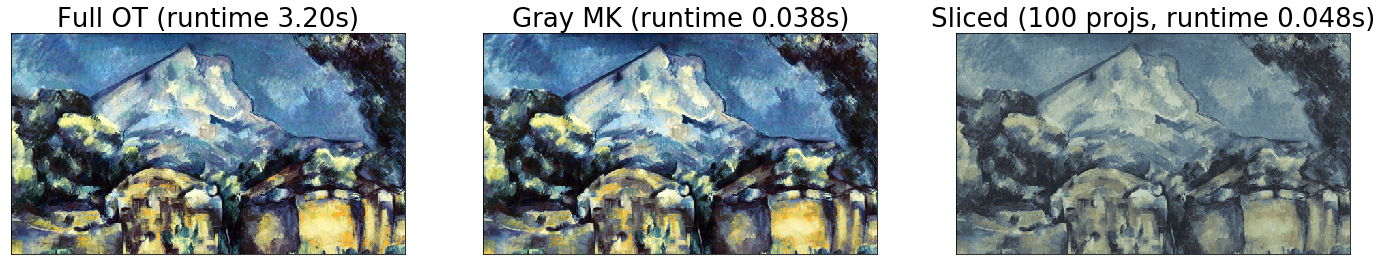

In [20]:
f, ax = plt.subplots(1, 3, figsize=(24, 6))


ax[0].imshow(img_ot_transf)
ax[1].imshow(img_gray_transf)
ax[2].imshow(img_sliced_transf)



ax[0].set_title(('Full OT (runtime {:.2f}s)').format(end_ot - start_ot), fontsize = 26)
ax[1].set_title(('Gray MK (runtime {:.3f}s)').format(end_mk - start_mk), fontsize = 26)
ax[2].set_title(('Sliced ({} projs, runtime {:.3f}s)').format(num_projs, end_sliced - start_sliced), fontsize=26)



for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)    
    
plt.show()